In [ ]:
#
# Charlie Marshak, Orinoco: Retrieving a River Delta Network with the Fast Marching Method and Python
# https://www.mdpi.com/2220-9964/9/11/658
#
# Brian E. Chapman Automated Generation of Directed Graphs from Vascular Segmentations
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4547695

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import SimpleITK as sitk
from scipy import ndimage
import numpy as np
import networkx as nx
import skfmm
from skimage import measure, filters, graph
from skimage.morphology import skeletonize
from skimage.segmentation import watershed


# finding branches using - skeletonization

(312, 312, 301) (1.0, 1.0, 1.0)


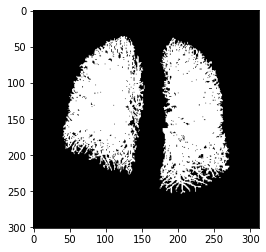

In [3]:
mask_obj = sitk.ReadImage("lung_vessels.nii.gz")

print(mask_obj.GetSize(),mask_obj.GetSpacing())
mask = sitk.GetArrayFromImage(mask_obj)
plt.imshow(np.max(mask,1),cmap='gray')

skeletonize...
skeleton voxel count: 37683
intersection...
8131 8130
watershed...
8131


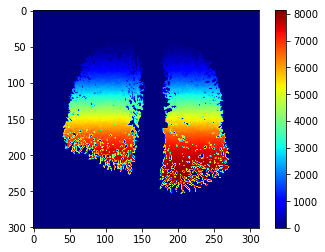

In [4]:
print('skeletonize...')
skeleton = skeletonize(mask)
skeleton = skeleton.astype(np.int32)
print(f'skeleton voxel count: {np.sum(skeleton)}')

print('intersection...')
weights = np.ones((3,3,3))
intersection = ndimage.convolve(skeleton,weights) > 3

branch = np.copy(skeleton).astype(np.int32)
branch[intersection==1]=0
label = measure.label(branch)
props = measure.regionprops(label)

print(len(np.unique(label)),len(props))

print('watershed...')
ws_branch = watershed(mask*-1, label, mask=mask>0)
ws_branch = ws_branch.astype(np.int32)

print(len(np.unique(ws_branch)))
plt.imshow(np.max(ws_branch,1),cmap='jet')
plt.colorbar()



In [5]:

mytmp = ws_branch.astype(np.uint8) # use less colors

mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')

# finding branches using - fast marching

(312, 312, 301) (1.0, 1.0, 1.0)


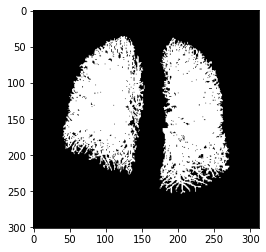

In [6]:
mask_obj = sitk.ReadImage("lung_vessels.nii.gz")
print(mask_obj.GetSize(),mask_obj.GetSpacing())
mask = sitk.GetArrayFromImage(mask_obj)

plt.imshow(np.max(mask,1),cmap='gray')

4.0


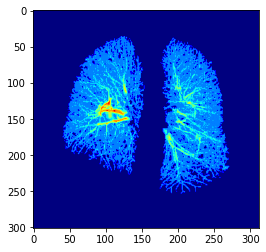

In [7]:
# use bsfield to find starting point for skfmm
bsfield = ndimage.distance_transform_edt(mask)
ssfield = np.zeros_like(bsfield).astype(np.int32)
print(np.max(bsfield))
plt.imshow(np.max(bsfield,1),cmap='jet')

1093


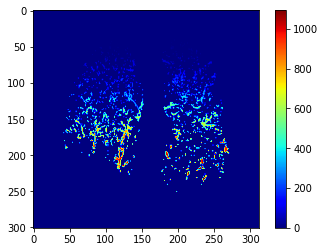

In [8]:
# use label and regionprops perform fmm for each non-connected region

label = measure.label(mask)
props = measure.regionprops(label)

print(len(np.unique(label)))
plt.imshow(np.max(label,1),cmap='jet')
plt.colorbar()

th (voxels) 1000.0
[2, 3]
78538.0
4.0 1
13492854


<ipython-input-28-9b7b9ebb5476>:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  item_ssfield = get_point_seeded_field(item_region,item_seed).astype(np.float)


4035 downsampled
<class 'skimage.graph._rag.RAG'>
1.0
3.0 1
12512039
3567 downsampled
<class 'skimage.graph._rag.RAG'>


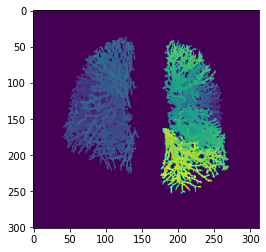

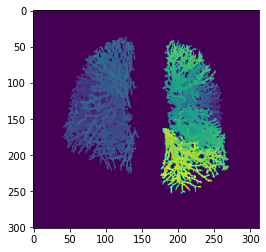

In [28]:


def get_point_seeded_field(mask,seed_ind):
    sx,sy,sz = np.unravel_index(seed_ind,mask.shape)
    mask = ~ mask.astype(bool)
    m = np.ones_like(mask)
    m[sx,sy,sz] = 0
    m = np.ma.masked_array(m, mask)
    ss_field = skfmm.distance(m,dx=1) # 
    return ss_field


th = 1000/np.prod(mask_obj.GetSpacing()) # 1cc in voxels
print('th (voxels)',th)
label_list = [x.label for x in props if x.label != 0 and x.area >= th]
print(label_list)


mydict = {}
for idx in label_list:
    item_region = label == idx
    print(props[idx].area)
    
    
    item_skeleton = skeletonize(item_region)
    item_bs = np.copy(bsfield) # find centered large point as starting point.
    item_bs[item_skeleton==0]=0
    max_val = np.max(item_bs)
    print(max_val,np.sum(item_bs == max_val))
    item_seed = np.argmax(item_bs)
    print(np.argmax(item_bs))
    
    
    item_ssfield = get_point_seeded_field(item_region,item_seed).astype(np.float)
    
    # ssfield is not always propagating normal to vessel direction
    # we downsample the intensity
    item_ssfield /= 4 # arbitrary number

    # use skeleton then watershed
    #item_ssfield = get_point_seeded_field(item_skeleton,item_seed).astype(np.int32)
    #print(len(np.unique(item_ssfield)),'downsampled')
    #item_ssfield = watershed(item_region*-1, item_ssfield, mask=item_region>0)
    #print(len(np.unique(item_ssfield)),'downsampled')
    
    
    item_label = measure.label(item_ssfield)
    ssfield[ item_ssfield.mask == False ]=item_ssfield[item_ssfield.mask == False] # ???? why ssfield cannot be merged?
    
    print(len(np.unique(item_label)),'downsampled')
    item_rag = graph.RAG(label_image=item_label,connectivity=3) # you can use this 
    print(type(item_rag))
    plt.figure(idx)
    plt.imshow(np.max(ssfield,axis=1))
    #item_rag.remove_node(0)
    mydict[idx]={'rag':item_rag,'ssfield':item_ssfield,'label':item_label}

int32


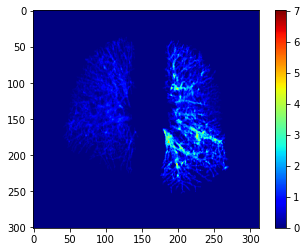

In [23]:
print(ssfield.dtype)
plt.imshow(np.mean(ssfield,1),cmap='jet')
plt.colorbar()

In [24]:
mytmp = ssfield.astype(np.uint8)
mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')

In [25]:
for k,v in mydict.items():
    print(k,v.keys())

2 dict_keys(['rag', 'ssfield', 'label'])
3 dict_keys(['rag', 'ssfield', 'label'])


In [27]:
mytmp = np.zeros_like(mask).astype(np.uint8) # use less colors

for k,v in mydict.items():
    #v['rag'].remove_node(0)
    item_rag = v['rag']
    item_label = v['label']
    print(len(np.unique(item_label)))
    item_props = measure.regionprops(item_label)
    print(len(item_props))
    for (n, data), r in zip(item_rag.nodes(data=True), item_props):
        if n == 0:
            continue
        edge_list = nx.edges(item_rag,[n])
        if len(edge_list) == 0:
            value = 4 # island
        elif len(edge_list) == 1:
            value = 1 # endpoint
        elif len(edge_list) == 2:
            value = 2 # branch
        else:
            value = 3 # intersection
        mytmp[item_label==n]=value
        
mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')


2
0
2
0


In [ ]:
mytmp_obj = sitk.GetImageFromArray(mytmp)
mytmp_obj.CopyInformation(mask_obj)
sitk.WriteImage(mytmp_obj,'mytmp.nii.gz')



In [ ]:
rag = mydict[2]['rag']

print(type(rag))
print(dir(rag))

In [ ]:
print(rag.number_of_edges(),rag.number_of_nodes())

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for k,v in mydict.items():
    item_rag = v['rag']
    item_label = v['label']
    item_props = measure.regionprops(item_label)
    for (n, data), region in zip(item_rag.nodes(data=True), item_props):
        data['pos'] = tuple(map(int, region['centroid'] ))

    # Extract node and edge positions from the layout
    item_dict = {k:v for k,v in item_rag.nodes(data=True)}
    node_xyz = np.array([item_dict[v]['pos'] for v in sorted(item_rag)])
    print(node_xyz.shape)
    edge_xyz = np.array([(item_dict[u]['pos'],item_dict[v]['pos']) for u, v in item_rag.edges()])
    print(edge_xyz.shape)

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=1, ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()
